## Day 21 Lecture 2 Assignment

In this assignment, we will apply techniques for identifying and dealing with outliers to a dataset containing information about Uber rides.

In [18]:
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [61]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ssl
from scipy.stats.mstats import winsorize

ssl._create_default_https_context = ssl._create_unverified_context

<IPython.core.display.Javascript object>

In [47]:
uber_data = pd.read_csv(
    "https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/uber_rides.csv"
)

<IPython.core.display.Javascript object>

In [48]:
uber_data.head()

,trip_uid,trip_time,total_time,wait_time,price_rub,price_usd,distance_kms,temperature_value,feels_like,humidity,wind_speed,cloudness
0,ee89076fd9da9bddf5f096b0ca42f8d5,0:21:33,0:29:00,0:07:27,265,5.17,9.29,12,12,0.69,4.81,0.78
1,518be51d403944a03c47e8d1f2c87311,0:19:27,0:26:00,0:06:33,255,4.97,9.93,10,10,0.70,6.53,0.66
2,6e460cc8a12c3c6568d0d4a67ac58393,1:06:53,1:23:00,0:16:07,644,13.01,18.01,14,14,0.61,5.25,0.86
3,49613a86a04e6c15d72b51d1a2935d81,0:13:37,0:20:00,0:06:23,1287,25.99,5.10,3,3,0.84,0.87,0.56
4,9896148fdecdb4c5d977a8691510bdb6,0:38:54,0:49:00,0:10:06,665,13.43,21.92,3,1,0.90,1.61,0.31


<IPython.core.display.Javascript object>

Before we identify outliers in the given columns, we need to address three time columns (trip_time, total_time, and wait_time), which are provided as formatted strings (HH:MM:SS) instead of numeric values. Convert the values in these three columns into their numeric equivalents in minutes - "2:15" should be converted to "2.25", "1:22:30" should be converted to "82.5", and so on. You may find it helpful to write a function that does this and use the .apply() function to apply it to all of the necessary columns.

In [67]:
s = "1:22:30"

time_split = s.split(":")
time_split
time_split = [int(i) for i in time_split]
hours = time_split[0] * 60
minutes = time_split[1]
seconds = time_split[2] / 60
time_int = hours + minutes + seconds
time_int

82.5

<IPython.core.display.Javascript object>

In [49]:
def time_to_int(time):
    time_split = time.split(":")
    time_split = [int(i) for i in time_split]
    hours = time_split[0] * 60
    minutes = time_split[1]
    seconds = time_split[2] / 60
    time_int = hours + minutes + seconds

    return time_int


for elem in list(uber_data):
    if elem.endswith("time") == True:
        uber_data[elem] = uber_data[elem].apply(time_to_int)

uber_data





,trip_uid,trip_time,total_time,wait_time,price_rub,price_usd,distance_kms,temperature_value,feels_like,humidity,wind_speed,cloudness
0,ee89076fd9da9bddf5f096b0ca42f8d5,21.550000,29.0,7.450000,265,5.17,9.29,12,12,0.69,4.81,0.78
1,518be51d403944a03c47e8d1f2c87311,19.450000,26.0,6.550000,255,4.97,9.93,10,10,0.70,6.53,0.66
2,6e460cc8a12c3c6568d0d4a67ac58393,66.883333,83.0,16.116667,644,13.01,18.01,14,14,0.61,5.25,0.86
3,49613a86a04e6c15d72b51d1a2935d81,13.616667,20.0,6.383333,1287,25.99,5.10,3,3,0.84,0.87,0.56
4,9896148fdecdb4c5d977a8691510bdb6,38.900000,49.0,10.100000,665,13.43,21.92,3,1,0.90,1.61,0.31
...,...,...,...,...,...,...,...,...,...,...,...,...
673,ce5bdea8e9c366b2f9f9cdf1bb879965,10.616667,12.0,1.383333,161,2.60,5.79,6,4,0.39,2.57,0.18
674,3a1df88ce67d8f749ac5f09da8b4dadf,23.683333,37.0,13.316667,241,3.92,11.46,7,3,0.62,5.37,0.48
675,1879ce44367d4cc555479253323ec36d,16.333333,35.0,18.666667,174,2.78,6.68,8,6,0.76,4.02,0.9
676,7a237cb245b6ca854498ecb7c842beb3,19.316667,23.0,3.683333,209,3.33,7.48,9,7,0.68,4.28,0.79


<IPython.core.display.Javascript object>

Plot histograms for each of the column, excluding the trip ID. Which features appear to have outliers? What do you suspect the nature of these outliers is (i.e. do you think these are most likely data errors, or correct values that are simply unusually large or small?)

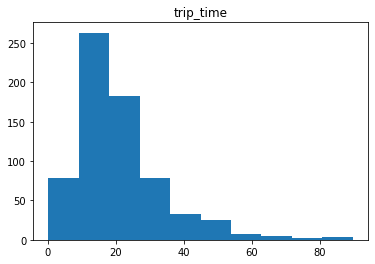

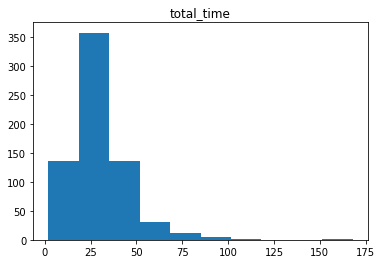

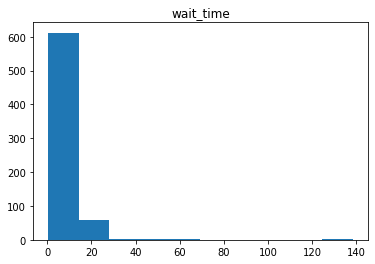

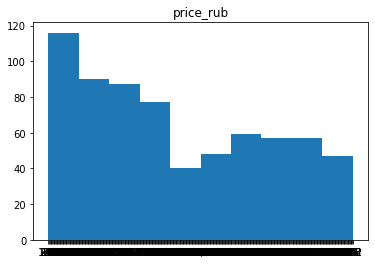

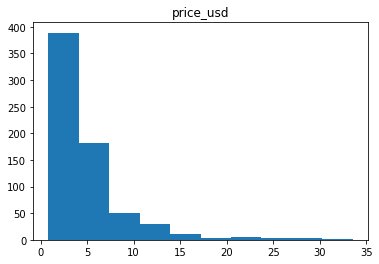

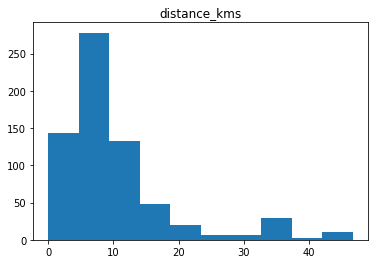

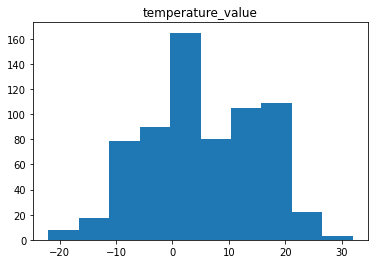

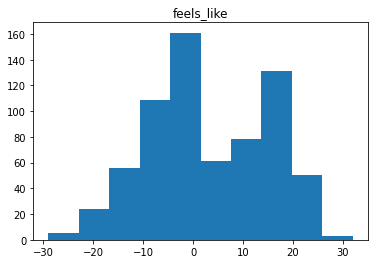

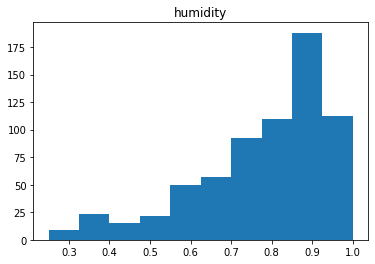

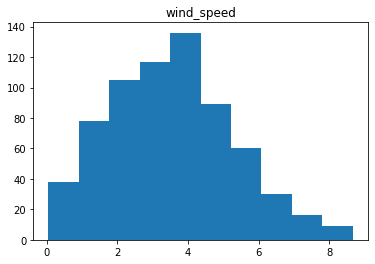

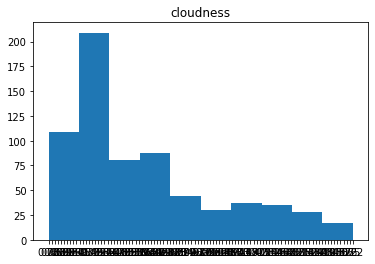

<IPython.core.display.Javascript object>

In [50]:
for column in list(uber_data):
    if column!='trip_uid':
        plt.hist(uber_data[column])
        plt.title(column)
        plt.show()




Using Tukey's IQR method and a threshold value of 1.5, how many trips have trip_time values that are identified as outliers? Print these trips out.

In [64]:
q75, q25 = np.percentile(uber_data["trip_time"], [75, 25])
iqr = q75 - q25

threshold = 1.5

min_val = q25 - (iqr * threshold)
max_val = q75 + (iqr * threshold)

print(min_val, max_val, "\n")

print(
    "Outliers:",
    len(
        (
            np.where(
                (uber_data["trip_time"] > max_val) | (uber_data["trip_time"] < min_val)
            )[0]
        )
    ),
)

print(np.where((uber_data["trip_time"] > max_val) | (uber_data["trip_time"] < min_val)))

-8.545833333333336 47.487500000000004 

Outliers: 30
(array([  2,  13,  29,  45,  47,  79, 106, 108, 117, 201, 253, 277, 291,
       339, 367, 411, 413, 414, 432, 472, 473, 474, 519, 520, 590, 591,
       600, 601, 646, 647]),)


<IPython.core.display.Javascript object>

There are various ways of handling outliers, including "clipping" (also called "winsorizing"). Clip the outliers to the appropriate upper/lower threshold calculated as part of Tukey's method. Plot the histogram for trip_time after clipping; how does it look different?

In [70]:
winsorized_time = winsorize(uber_data["trip_time"], (0, 0.10))
winsorized_time

masked_array(data=[21.55      , 19.45      , 36.7       , 13.61666667,
                   36.7       , 16.63333333, 36.7       , 36.7       ,
                   10.1       , 25.5       , 17.78333333, 14.46666667,
                   15.31666667, 36.7       , 12.65      , 16.3       ,
                   11.45      , 16.65      , 16.46666667, 14.21666667,
                   21.2       ,  1.        , 36.7       , 30.73333333,
                   25.3       , 30.3       ,  9.55      , 22.51666667,
                   36.7       , 36.7       , 12.46666667, 10.58333333,
                    5.76666667, 16.51666667,  8.85      , 12.1       ,
                   17.51666667,  9.71666667, 18.4       ,  7.5       ,
                   10.33333333, 31.15      , 28.28333333, 29.83333333,
                   11.65      , 36.7       , 31.33333333, 36.7       ,
                   36.7       , 36.7       ,  5.4       , 23.66666667,
                   13.48333333, 30.41666667, 24.58333333, 11.45      ,
      

<IPython.core.display.Javascript object>